<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/integrate_kl_loss/dnn/variational_split_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil. At the bottom of the colab, train and evaluate 4 different versions of the model with different data partitioning strategies.

In [ ]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = True #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR,'variational/model', filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/drive', GDRIVE_DIR)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

# Data preparation


In [ ]:
def load_dataset(path: str):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]

  # Family is too sparse. Too many families exist in validation/test that won't
  # exist in train, so drop it.
  X = df.drop(["d18O_cel_mean", "d18O_cel_variance", "Code", "Family", "Unnamed: 0"], axis=1)
  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]
  return X, Y

Standardization

In [ ]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame) -> ColumnTransformer:
  columns_to_normalize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
       'Mean Annual Temperature', 'Mean Annual Precipitation']
  columns_to_standardize = ['Iso_Oxi_Stack_mean_TERZER',
                            'predkrig_br_lat_ISORG',
                            'isoscape_fullmodel_d18O_prec_REGRESSION']
  feature_scaler = ColumnTransformer([
      ('feature_normalizer', Normalizer(), columns_to_normalize),
      ('feature_standardizer', StandardScaler(), columns_to_standardize)],
      remainder='passthrough')
  feature_scaler.fit(X)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame) -> ColumnTransformer:
  label_scaler = ColumnTransformer([
      ('mean_std_scaler', StandardScaler(), ['d18O_cel_mean']),
      ('var_minmax_scaler', MinMaxScaler(), ['d18O_cel_variance'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, Y: pd.DataFrame, feature_scaler, label_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  # Y_standardized = pd.DataFrame(label_scaler.transform(Y),
  #                                     index=Y.index, columns=Y.columns)
  # FOR NOW, DO NOT SCALE Y.
  return FeaturesToLabels(X_standardized, Y)

In [ ]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict) -> ScaledPartitions:
  X_train, Y_train = load_dataset(config['TRAIN'])
  X_val, Y_val = load_dataset(config['VALIDATION'])
  X_test, Y_test = load_dataset(config['TEST'])

  feature_scaler = create_feature_scaler(X_train)
  label_scaler = create_label_scaler(Y_train)
  train = scale(X_train, Y_train, feature_scaler, label_scaler)
  val = scale(X_val, Y_val, feature_scaler, label_scaler)
  test = scale(X_test, Y_test, feature_scaler, label_scaler)
  return ScaledPartitions(feature_scaler, label_scaler, train, val, test)


# Model Definition

## The KL Loss function:

In [ ]:
def sample_normal_distribution(
    mean: tf.Tensor,
    stdev: tf.Tensor,
    n: int) -> tf.Tensor:
    '''
    Given a batch of normal distributions described by a mean and stdev in
    a tf.Tensor, sample n elements from each distribution and return the mean
    and standard deviation per sample.
    '''
    batch_size = tf.shape(mean)[0]

    # Output tensor is (n, batch_size, 1)
    sample_values = tfp.distributions.Normal(
        loc=mean,
        scale=stdev).sample(
            sample_shape=n)
    # Reshaped tensor will be (batch_size, n)
    sample_values = tf.transpose(sample_values)
    # Get the mean per sample in the batch.
    sample_mean = tf.transpose(tf.math.reduce_mean(sample_values, 2))
    sample_stdev = tf.transpose(tf.math.reduce_std(sample_values, 2))

    return sample_mean, sample_stdev

import tensorflow_probability as tfp

# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence_helper(real, predicted, sample):
    '''
    real: tf.Tensor of the real mean and standard deviation of sample to compare
    predicted: tf.Tensor of the predicted mean and standard deviation to compare
    sample: Whether or not to sample the predicted distribution to get a new
            mean and standard deviation.
    '''
    if real.shape != predicted.shape:
      raise ValueError(
          f"real.shape {real.shape} != predicted.shape {predicted.shape}")

    real_value = tf.gather(real, [0], axis=1)
    real_std = tf.math.sqrt(tf.gather(real, [1], axis=1))

    predicted_value = tf.gather(predicted, [0], axis=1)
    predicted_std = tf.math.sqrt(tf.gather(predicted, [1], axis=1))
    # If true, sample from the distribution defined by the predicted mean and
    # standard deviation to use for mean and stdev used in KL divergence loss.
    if sample:
      predicted_value, predicted_std = sample_normal_distribution(
          mean=predicted_value, stdev=predicted_std, n=5)

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_value - predicted_value))/ \
     (2*tf.square(predicted_std))

    return tf.math.reduce_mean(kl_loss)

def kl_divergence(real, predicted):
  return kl_divergence_helper(real, predicted, False)

In [ ]:
### Testing the loss function:

In [ ]:
import pytest
tf.random.set_seed(1871)
def test_sample_normal_distribution():
  mean = tf.convert_to_tensor(np.array([[100.0, 5.0]]))
  stdev = tf.convert_to_tensor(np.array([[200.0, 10.0]]))
  n = 1000000

  sample_mean, sample_stdev = sample_normal_distribution(mean, stdev, n)
  assert sample_mean.numpy()[0][0] == pytest.approx(mean.numpy()[0][0], 1e-1)
  assert sample_mean.numpy()[0][1] == pytest.approx(mean.numpy()[0][1], 1e-1)
  assert sample_stdev.numpy()[0][0] == pytest.approx(stdev.numpy()[0][0], 1e-1)
  assert sample_stdev.numpy()[0][1] == pytest.approx(stdev.numpy()[0][1], 1e-1)

test_sample_normal_distribution()

In [ ]:
import pytest

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

# Calculated manually by computing the result of this equation in wolfram alpha:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

In [ ]:
import unittest

class TensorsDifferShapeTest(unittest.TestCase):
   def test(self):
      test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
      test_pred = tf.convert_to_tensor(np.array([[0.98]]))
      with self.assertRaises(ValueError):
         kl_divergence(test_real, test_pred, False)
         assert(False) # Triggers if no exception is caught in the previous line.

TensorsDifferShapeTest().test()

Model definition

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=10)

tf.keras.utils.set_random_seed(18731)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:
    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    x = inputs
    for layer_size in hidden_layers:
      x = keras.layers.Dense(
          layer_size, activation='relu')(x)
    mean_output = keras.layers.Dense(
        1, name='mean_output')(x)

    # We can not have negative variance. Apply very little variance.
    var_output = keras.layers.Dense(
        1, name='var_output')(x)

    # Invert the normalization on our outputs
    mean_scaler = sp.label_scaler.named_transformers_['mean_std_scaler']
    untransformed_mean = mean_output * mean_scaler.var_ + mean_scaler.mean_

    var_scaler = sp.label_scaler.named_transformers_['var_minmax_scaler']
    unscaled_var = var_output * var_scaler.scale_ + var_scaler.min_
    untransformed_var = keras.layers.Lambda(lambda t: tf.math.log(1 + tf.exp(t)))(unscaled_var)

    # Output mean, |variance| tuples.
    outputs = keras.layers.concatenate([untransformed_mean, untransformed_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Later epochs seem to benefit from lower learning rate... but it takes
    # a while to get there.
    decay = keras.optimizers.schedules.ExponentialDecay(
       lr, decay_steps=100, decay_rate=0.5, staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=0, epochs=epochs, batch_size=batch_size,
                      validation_data=sp.val.as_tuple(),
                      shuffle=True, callbacks=callbacks_list)
  return history, model

In [ ]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=5000, batch_size=training_batch_size,
      lr=0.0001, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")
  print('Model saved to', get_model_save_location(run_id+".h5"))

  best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
  print('Best epoch:', best_epoch_index)
  print('Val loss:', history.history['val_loss'][best_epoch_index])
  print('Train loss:', history.history['loss'][best_epoch_index])
  print('Test loss:', model.evaluate(x=sp.test.X, y=sp.test.Y, verbose=0))

  test_predictions = model.predict_on_batch(sp.test.X)
  test_predictions = pd.DataFrame(test_predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  test_rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_cel_mean'], test_predictions['d18O_cel_mean']))
  print("dO18 Test RMSE: "+ str(test_rmse))

  val_predictions = model.predict_on_batch(sp.val.X)
  val_predictions = pd.DataFrame(val_predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  val_rmse = np.sqrt(mean_squared_error(sp.val.Y['d18O_cel_mean'], val_predictions['d18O_cel_mean']))
  print("dO18 Val RMSE: "+ str(val_rmse))

  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  print(test_predictions.to_string())
  return model

# Load and evaluate the model with each set of data.

Use the same model configured the same way for every run, with the exception of the training batch size setting, which is 1 for grouped and 5 for ungrouped.

### 1) Ungrouped, random

ungrouped_random
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           260         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           420         ['dense[0][0]']                  
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_1[0][0]']                
                                                                             

/tmp/ipykernel_2030896/1627486282.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


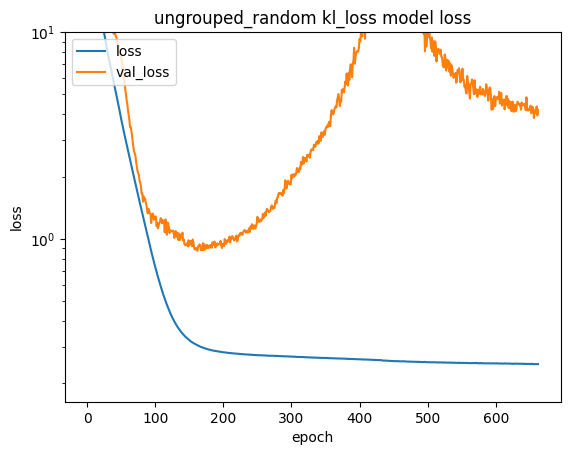

2/2 [==============================] - 0s 2ms/step - loss: 0.5675
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       26.663818           0.574594
1       26.663818           0.574594
2       26.663818           0.574594
3       27.559140           0.780698
4       27.559140           0.780698
5       27.559140           0.780698
6       27.559140           0.780698
7       27.559140           0.780698
8       27.559140           0.780698
9       27.559140           0.780698
10      27.559140           0.780698
11      27.559140           0.780698
12      27.559140           0.780698
13      27.260748           0.830341
14      27.260748           0.830341
15      27.260748           0.830341
16      27.260748           0.830341
17      27.260748           0.830341
18      27.260748           0.830341
19      27.260748           0.830341
20      27.260748           0.830341
21      27.260748           0.830341
22      27.260748           0.830341
23      27.260748           0.830341

2023-07-21 16:30:24.953275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [63,12]
	 [[{{node Placeholder/_0}}]]


In [ ]:
ungrouped_random = {
    'TRAIN' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_train_random_ungrouped.csv"),
    'TEST' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_test_random_ungrouped.csv"),
    'VALIDATION' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_validation_random_ungrouped.csv"),
}

ungrouped_random_scaled = load_and_scale(ungrouped_random)
train_and_evaluate(ungrouped_random_scaled, "ungrouped_random", training_batch_size=3)

### 2) Ungrouped, fixed

ungrouped_fixed
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 20)           260         ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 20)           420         ['dense_2[0][0]']                
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_3[0][0]']                
                                                                            

/tmp/ipykernel_1859096/1627486282.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


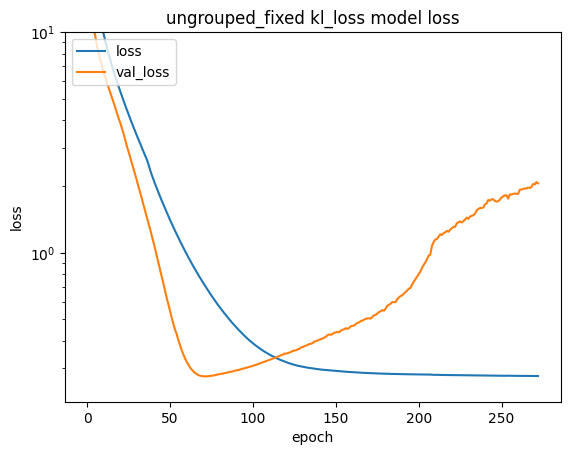

4/4 [==============================] - 0s 1ms/step - loss: 1.2240
EXPECTED:
     d18O_cel_mean  d18O_cel_variance
0        25.120750           0.844007
1        25.120750           0.844007
2        25.120750           0.844007
3        25.120750           0.844007
4        25.120750           0.844007
5        25.120750           0.844007
6        25.120750           0.844007
7        25.120750           0.844007
8        25.120750           0.844007
9        25.120750           0.844007
10       25.120750           0.844007
11       25.120750           0.844007
12       25.120750           0.844007
13       25.120750           0.844007
14       25.120750           0.844007
15       25.120750           0.844007
16       25.120750           0.844007
17       25.120750           0.844007
18       25.120750           0.844007
19       25.120750           0.844007
20       25.120750           0.844007
21       25.120750           0.844007
22       25.120750           0.844007
23       25.

2023-07-21 16:13:02.436594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [109,12]
	 [[{{node Placeholder/_0}}]]


In [ ]:
ungrouped_fixed = {
    'TRAIN' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_train_fixed_ungrouped.csv"),
    'TEST' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_test_fixed_ungrouped.csv"),
    'VALIDATION' : os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_validation_fixed_ungrouped.csv"),
}

ungrouped_fixed_scaled = load_and_scale(ungrouped_fixed)
train_and_evaluate(ungrouped_fixed_scaled, "ungrouped_fixed", training_batch_size=3)

### 3) Grouped, random

grouped_random
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 20)           260         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           420         ['dense[0][0]']                  
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_1[0][0]']                
                                                                               

/tmp/ipykernel_1859096/1627486282.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


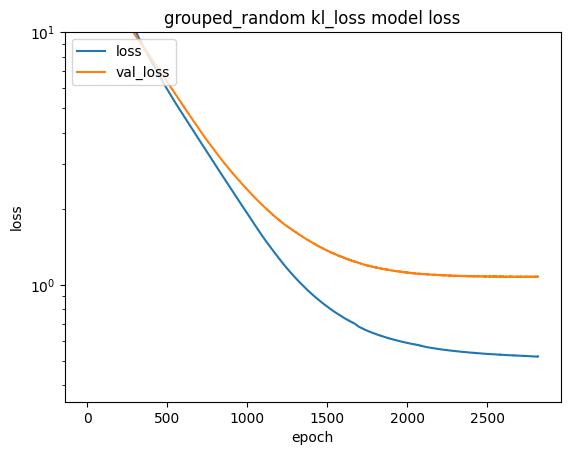

1/1 [==============================] - 0s 20ms/step - loss: 1.3383
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0      25.882000           0.233670
1      25.654000           0.334480
2      27.207456           1.041823
3      25.163333           0.807832
4      24.030630           0.579233
5      26.040923           0.222859

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      25.313137           1.562158
1      25.312395           1.559743
2      26.195196           1.306455
3      24.725636           0.186979
4      24.725636           0.186979
5      24.838568           0.214695
RMSE: 0.7730068369992796


2023-07-21 15:29:07.943723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [6,12]
	 [[{{node Placeholder/_0}}]]


In [ ]:
grouped_random = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_12_train_random_grouped.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_12_test_random_grouped.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_12_validation_random_grouped.csv'),
}

grouped_random_scaled = load_and_scale(grouped_random)
train_and_evaluate(grouped_random_scaled, "grouped_random", training_batch_size=3)

### 4) Grouped, fixed

grouped_fixed
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 20)           260         ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 20)           420         ['dense_4[0][0]']                
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_5[0][0]']                
                                                                              

/tmp/ipykernel_2030896/1627486282.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


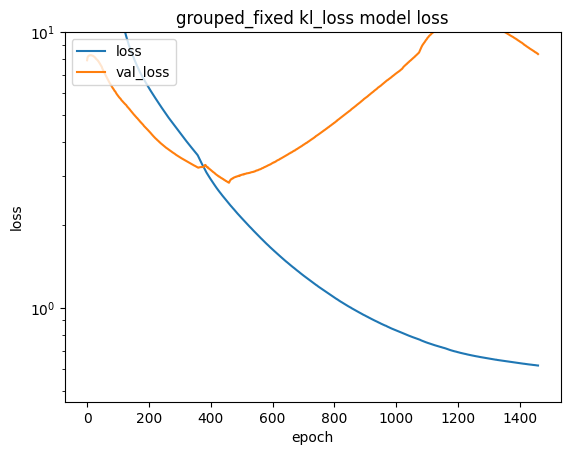

1/1 [==============================] - 0s 19ms/step - loss: 3.0377
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0      27.559140           0.780698
1      27.260748           0.830341
2      24.777670           0.736571
3      25.987815           5.280825
4      25.551850           0.312355
5      25.115885           0.033519
6      24.132031           0.389042
7      25.120750           0.844007

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      25.231573           0.381200
1      25.231701           0.380721
2      25.802017           0.468885
3      25.776625           0.549905
4      25.779470           0.561376
5      25.779909           0.559986
6      25.779293           0.561460
7      26.216799           0.239679
RMSE: 1.3709495477922276


2023-07-21 16:47:16.682008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [8,12]
	 [[{{node Placeholder/_0}}]]


In [ ]:
grouped_fixed = {
    'TRAIN': os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_train_fixed_grouped.csv"),
    'TEST': os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_test_fixed_grouped.csv"),
    'VALIDATION': os.path.join(FP_ROOT, "amazon_sample_data/uc_davis_2023_08_12_validation_fixed_grouped.csv"),
}

grouped_fixed_scaled = load_and_scale(grouped_fixed)
train_and_evaluate(grouped_fixed_scaled, "grouped_fixed", training_batch_size=3)